In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
import csv
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# LINK: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data?resource=download&select=temperature.csv
import math
from datetime import datetime

def year_periodic_function(date_str):
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")

    day_of_year = date_obj.timetuple().tm_yday

    phase_shift = math.pi / 2

    sin_value = math.sin((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    sin_function = 1 - (sin_value + 1) / 2

    cos_value = math.cos((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    cos_function = 1 - (cos_value + 1) / 2

    return sin_function, cos_function

class WeatherData:
    def __init__(self):
       self.metrics = {
            "temp": "156project/temperature.csv",
            "wind_direction": "156project/wind_direction.csv",
            "wind_speed": "156project/wind_speed.csv",
            "pressure": "156project/pressure.csv",
            "humidity": "156project/humidity.csv",
       }

       self.places = [
           "Vancouver",
           "Portland",
           "San Francisco",
           "Seattle",
           "Los Angeles",
           "San Diego",
           "Las Vegas",
           "Phoenix",
           "Albuquerque",
           "Denver",
           "San Antonio",
           "Dallas",
           "Houston",
           "Kansas City",
           "Minneapolis",
           "Saint Louis",
           "Chicago",
           "Nashville",
           "Indianapolis",
           "Atlanta",
           "Detroit",
           "Jacksonville",
           "Charlotte",
           "Miami",
           "Pittsburgh",
           "Toronto",
           "Philadelphia",
           "New York",
           "Montreal",
           "Boston",
           "Beersheba",
           "Tel Aviv District",
           "Eilat",
           "Haifa",
           "Nahariyya",
           "Jerusalem"
       ]

       self.import_all_rows()

    def compute_rolling_average(self, data, window_size=10):
        if len(data) < window_size:
            return np.array([])

        cumsum = np.cumsum(np.insert(data, 0, 0))
        rolling_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
        return rolling_avg

    # creates the mapping (metric_id -> city_name -> array of that metric in that city)
    def import_all_rows(self):
        data_map = {}

        for metric_key, csv_path in self.metrics.items():
            data_map[metric_key] = {}
            data_map["time_sin"] = {}
            data_map["time_sin_year"] = {}
            data_map["time_cos"] = {}
            data_map["time_cos_year"] = {}

            for place in self.places:
                data_map[metric_key][place] = []
                data_map["time_sin"][place] = []
                data_map["time_sin_year"][place] = []
                data_map["time_cos"][place] = []
                data_map["time_cos_year"][place] = []


            with open(csv_path, mode='r', encoding='utf-8') as file:
                csv_reader = csv.reader(file)
                # skip the first row since it is the header
                next(csv_reader)

                # skip the second row since it is empty in this dataset
                next(csv_reader)
                for row in csv_reader:
                    t = float(row[0][11:13])

                    t_sin = 0.5*math.sin(math.pi * 2 * (1/24) * (t+6)) + 0.5
                    t_cos = 0.5*math.cos(math.pi * 2 * (1/24) * (t+6)) + 0.5
                    t_sin_year, t_cos_year = year_periodic_function(row[0][0:10])

                    for city_index_i in range(len(self.places) - 1):
                        value = row[city_index_i + 1]
                        city_key = self.places[city_index_i + 1]

                        data_map["time_sin"][city_key].append(t_sin)
                        data_map["time_sin_year"][city_key].append(t_sin_year)
                        data_map["time_cos"][city_key].append(t_cos)
                        data_map["time_cos_year"][city_key].append(t_cos_year)

                        if value == "":
                            last_val_index = len(data_map[metric_key][city_key]) - 1

                            last_val = 0
                            if last_val_index != -1:
                                last_val = data_map[metric_key][city_key][last_val_index]
                            data_map[metric_key][city_key].append(last_val)
                        else:
                            data_map[metric_key][city_key].append(float(value))



            # data_map[metric_key] = np.array(data_map[metric_key])

        self.data_map = data_map

    def get_metric(self, metric, place, rolling=False, norm=False):
        data = []
        if rolling:
            data = self.compute_rolling_average(self.data_map[metric][place])
        else:
            data = self.data_map[metric][place]

        if norm:
            return self.norm(data)

        return data

    def norm(self, x):
        max = np.max(x)
        min = np.min(x)
        return (x-min)/(max-min)



weather_data = WeatherData()


Text(0.5, 0, 'Hours')

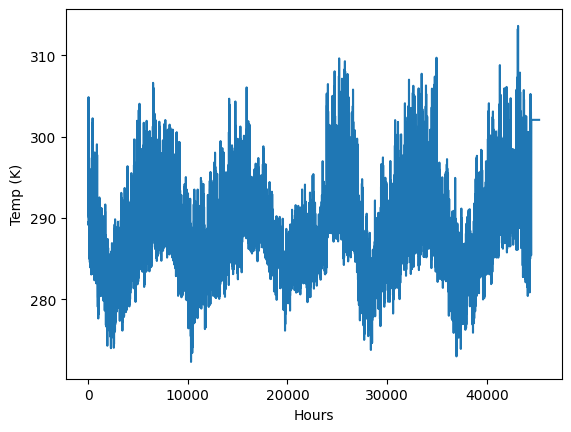

In [6]:
plt.plot(weather_data.get_metric("temp", "Seattle", rolling=False, norm=False))
plt.ylabel("Temp (K)")
plt.xlabel("Hours")

In [244]:
def chunk_list_input(lst, n):
    input_chunks = []

    for i in range(len(lst) - (2*n) + 1):
        input_row = []

        for j in range(n):
            input_row.append(lst[i+j])

        input_chunks.append(input_row)

    return input_chunks

def chunk_list_output(lst, input_size, n):
    input_chunks = []

    for i in range(len(lst) - (2*input_size) + 1):
        input_row = []

        for j in range(n):
            input_row.append(lst[input_size+i+j])

        input_chunks.append(input_row)

    return input_chunks

class LSTM_Approach():
    def __init__(self, input_metrics, output_metrics, input_window_size, output_window_size):
        self.input_metrics = input_metrics
        self.output_metrics = output_metrics
        self.input_window_size = input_window_size
        self.output_window_size = output_window_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, input_shape=(self.input_window_size, len(self.input_metrics)), 
                                 return_sequences=True),
            tf.keras.layers.LSTM(100),
            # tf.keras.layers.Dense(4*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dense(2*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.output_window_size)
        ])

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, inputs, outputs, epochs=50, stop_early=True):
        trimmed_x =  inputs[:int(len(inputs)*.8)]
        trimmed_y = outputs[:int(len(outputs)*.8)][:,:,0]

        if stop_early:
          callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
          self.model.fit(np.array(trimmed_x), np.array(trimmed_y), epochs=epochs, callbacks=[callback])
        else:
          self.model.fit(np.array(trimmed_x), np.array(trimmed_y), epochs=epochs)

    def evaluate(self, inputs, outputs):
        trimmed_x = inputs[int(len(inputs)*.8):]
        trimmed_y = outputs[int(len(outputs)*.8):][:,:,0]
        self.model.evaluate(trimmed_x, trimmed_y)


    def predict(self, input):
         return self.model.predict(input, verbose=0)
    
    def predit_at_time(self, time):
        points = []

        for input_metric in self.input_metrics:
            timeseries = weather_data.get_metric(input_metric[0], input_metric[1], rolling=False, norm=True)
            points.append(timeseries[time - self.input_window_size:time])

        input_vec = np.concatenate(points).reshape(1, -1)
        predicted = self.predict(input_vec)
        return predicted
    
    
    def get_training_data(self):
        all_input_chunks = []
        all_output_chunks = []
        for input_metric in self.input_metrics:
            raw_timeseries = weather_data.get_metric(input_metric[0], input_metric[1], rolling=False, norm=True)
            raw_timeseries = (raw_timeseries - np.mean(raw_timeseries))/np.std(raw_timeseries)
            input_chunks = chunk_list_input(raw_timeseries, self.input_window_size)

            all_input_chunks.append(np.transpose(input_chunks))

        for output_metric in self.output_metrics:
            raw_timeseries = weather_data.get_metric(output_metric[0], output_metric[1], rolling=False, norm=True)
            raw_timeseries = (raw_timeseries - np.mean(raw_timeseries))/np.std(raw_timeseries)
            output_chunks = chunk_list_output(raw_timeseries, self.input_window_size, self.output_window_size)

            all_output_chunks.append(np.transpose(output_chunks))

        return (np.transpose(all_input_chunks), np.transpose(all_output_chunks))
    

m = LSTM_Approach(
    # inputs to the model
    [
        # temp and pressure for other cities
        ("temp", "San Diego"),
        ("pressure", "San Diego"),

        # ("temp", "San Francisco"),
        # ("pressure", "San Francisco"),

        # ("temp", "Portland"),
        # ("pressure", "Portland"),

        # ("temp", "Kansas City"),
        # ("pressure", "Kansas City"),

        # ("temp", "Denver"),
        # ("pressure", "Denver"),

        # ("temp", "New York"),
        # ("pressure", "New York"),

        # ("temp", "Seattle"),
        # ("pressure", "Seattle"),


        # all data related to LA
        ("wind_speed", "Los Angeles"),
        ("humidity", "Los Angeles"),
        ("pressure", "Los Angeles"),
        ("time_sin", "Los Angeles"),
        ("time_sin_year", "Los Angeles"),
        ("time_cos", "Los Angeles"),
        ("time_cos_year", "Los Angeles"),
        ("temp", "Los Angeles"),
    ],
    # outputs to the model
    [
        ("temp", "Los Angeles")
    ],

    # number of hours to input
    24 * 3,

    # number of hours to predit
    24
)

In [121]:
inputs, outputs = m.get_training_data()
inputs.shape

(45109, 72, 10)

In [245]:
m.train(inputs, outputs, epochs=5)
# inputs.shape

Epoch 1/5
1128/1128 [==============================] - 70s 60ms/step - loss: 0.1140 - mae: 0.2518
Epoch 2/5
1128/1128 [==============================] - 68s 61ms/step - loss: 0.0770 - mae: 0.2100
Epoch 3/5
1128/1128 [==============================] - 69s 61ms/step - loss: 0.0644 - mae: 0.1917
Epoch 4/5
1128/1128 [==============================] - 69s 61ms/step - loss: 0.0518 - mae: 0.1722
Epoch 5/5
1128/1128 [==============================] - 68s 61ms/step - loss: 0.0404 - mae: 0.1524


In [266]:
m.evaluate(inputs, outputs)
# m.model.save('156_proj_5epoch_final.h5')

282/282 [==============================] - 5s 19ms/step - loss: 0.1247 - mae: 0.2670


/Users/davidspector/miniconda3/envs/tf-support/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


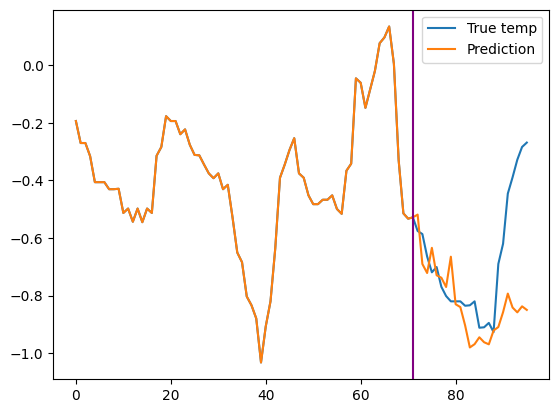

In [264]:
# Last day prediction
ind = -1
out = m.predict(np.array([inputs[ind]]))
plt.plot(np.concatenate((inputs[ind,:,-1],np.squeeze(outputs[ind]))), label="True temp")
plt.plot(np.concatenate((inputs[ind,:,-1],out[0])), label="Prediction")
plt.axvline(inputs.shape[1]-1, c='purple')
plt.legend()

In [242]:
# new_model = tf.keras.models.load_model('156_proj_22_acc_3days.h5')

# trimmed_x = inputs[int(len(inputs)*.8):]
# trimmed_y = outputs[int(len(outputs)*.8):][:,:,0]
# new_model.evaluate(trimmed_x, trimmed_y)

282/282 [==============================] - 6s 19ms/step - loss: 0.1268 - accuracy: 0.2260


[0.1267729550600052, 0.22600311040878296]

1/1 [==============================] - 0s 21ms/step


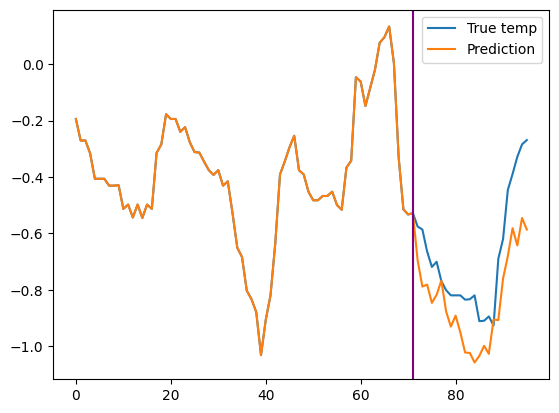

In [265]:
# Last day prediction
# # ind = -5
# out = new_model.predict(np.array([inputs[ind]]))
# plt.plot(np.concatenate((inputs[ind,:,-1],np.squeeze(outputs[ind]))), label="True temp")
# plt.plot(np.concatenate((inputs[ind,:,-1],out[0])), label="Prediction")
# plt.axvline(inputs.shape[1]-1, c='purple')
# plt.legend()